In [1]:
# %load_ext autoreload
# %autoreload 2

import os
import torch
from skimage import io, measure
import numpy as np
import matplotlib.pyplot as plt

from tifffile import imread, imsave

import warnings
warnings.filterwarnings('ignore')

from tifffile import imread




if not torch.cuda.is_available():
    raise ValueError("GPU not found, code will run on CPU and can be extremely slow!")
else:
    device = torch.device("cuda:0")

import time
from glob import glob
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint, EarlyStopping
import torch.optim as optim
import torch.utils.data as dt


import os
os.chdir('/mnt/c/Users/ankit/Desktop/Msc AIML/msc-project/GAP/gap')
from GAP_UNET_ResBlock_ffhq import UN
from BinomDataset_ffhq_inpaint import BinomDataset
from DataFolderFFHQ import DataFolder
from inferencev2 import sample_image
from tasks import inpainting

In [2]:
name = 'm40to30-256x256-ffhq'
CHECKPOINT_PATH = '/mnt/c/Users/ankit/Desktop/Msc AIML/Data/checkpoints/models/'

model = UN(channels = 3, levels=10, depth=6,start_filts=32, 
           up_mode = 'upsample', merge_mode = 'concat').to(device)
model = UN.load_from_checkpoint(os.path.join(CHECKPOINT_PATH, name)+'.ckpt').to(device)

In [3]:
ffhq_path = '/mnt/c/Users/ankit/Desktop/Msc AIML/Data/ffhq/'
minpsnr = -40
maxpsnr = 30
dataset = BinomDataset(ffhq_path, windowSize = 256, minPSNR = minpsnr, maxPSNR= maxpsnr, virtSize= 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 255.5, 255.5, -0.5)

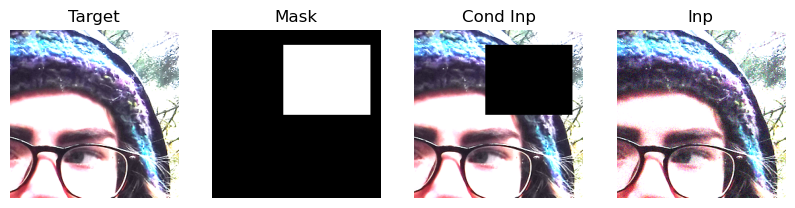

In [4]:
channels = 3
img = dataset[5000000000]
plt.figure(figsize= (10, 10))
plt.subplot(1, 4, 1)
plt.imshow(img[:channels].permute(1, 2, 0), vmin = 0, vmax = 255)
plt.title('Target')
plt.axis('off')
plt.subplot(1, 4, 2)
plt.imshow(img[channels:channels + 1].permute(1, 2, 0), vmin = 0, vmax = 1, cmap= 'gray')
plt.title('Mask')
plt.axis('off')
plt.subplot(1, 4, 3)
plt.imshow(img[channels + 1:channels  + 1 + 3].permute(1, 2, 0), vmin = 0, vmax = 255)
plt.title('Cond Inp')
plt.axis('off')
plt.subplot(1, 4, 4)
# plt.imshow(img[channels  + 1 + 3:channels  + 1 + 3 + 3].permute(1, 2, 0))
plt.imshow(img[channels  + 1 + 3:channels  + 1 + 3 + 3].permute(1, 2, 0)/img[channels  + 1 + 3:channels  + 1 + 3 + 3].permute(1, 2, 0).mean(), vmin = 0, vmax = 255)
plt.title('Inp')
plt.axis('off')
# stats(img[:channels].permute(1, 2, 0)), stats(img[channels  + 1 + 3:channels  + 1 + 3 + 3].permute(1, 2, 0)), 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 511.5, 511.5, -0.5)

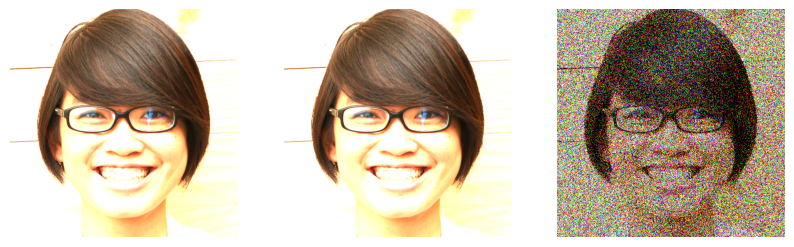

In [10]:
dataset = DataFolder(ffhq_path, minPSNR = minpsnr, maxPSNR= maxpsnr, virtSize= 1)
dataTestGT, dataTestTarget, dataTest = dataset[0]
plt.figure(figsize= (10, 10))
plt.subplot(1, 3, 1)
plt.imshow(dataTestGT.permute(1, 2, 0), vmin = 0, vmax = 255)
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(dataTestTarget.permute(1, 2, 0), vmin = 0, vmax = 1, cmap= 'gray')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(dataTest.permute(1, 2, 0), vmin = 0, vmax = 255)
plt.axis('off')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 512, 512])


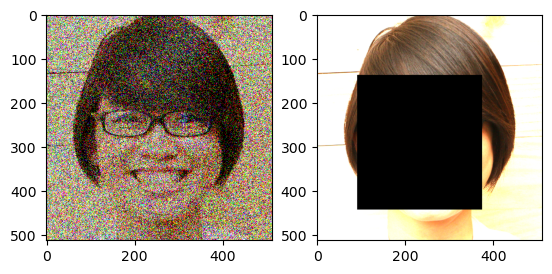

In [12]:
masks = inpainting(imgsize = 512, masksize = 256)
mask = masks.generate_mask().numpy()
test = dataTest 
testGT = dataTestGT/dataTestGT.mean()
cond_test = testGT * (1 - mask)
print(cond_test.shape)
plt.subplot(1, 2, 1)
plt.imshow(test.permute(1, 2, 0),)
plt.subplot(1, 2, 2)
plt.imshow(cond_test.permute(1, 2, 0))

In [13]:
dataTest.mean(), cond_test.mean()

(tensor(0.6593), tensor(0.7231))

In [15]:
dataTest.shape, cond_input.shape, dataTestGT.shape

(torch.Size([3, 512, 512]), (1, 4, 512, 512), torch.Size([3, 512, 512]))

In [14]:
cond_input = np.expand_dims(np.concatenate((mask, cond_test), axis = 0), axis = 0)

for inp, cinp, gt in zip(dataTest, cond_input, dataTestGT): 
    print(cinp.shape) 
    inpT = inp.to(device) 
    cond_inpT = cinp.to(device)
    inpT = torch.cat([cond_inpT, inpT[None]], dim = 0).to(device)
    print(f'input shape : {inpT.shape}, model input shape : {inpT[None].shape}')
    out = torch.exp(model(inpT[None]).detach().cpu())
    out = inp.sum() * out / out.sum() ## multiply noisy image with probability distribution of clean image?
    
    print(gt.max(), gt.min(), gt.std(), np.percentile(gt,99.9), np.percentile(gt,50))

    inp = inp/inp.mean()
    out = out/out.mean()
    gt = gt/gt.mean()
    cond_inp = cinp[1]/cinp[1].mean()

    
    print(f'inp shape : {inp.shape}')
    print(f'out shape : {out.shape}')
    print(f'gt shape : {gt.shape}')

    cond_vmax = np.percentile(cond_inp,99.9)
    plt.figure(figsize=(20,20))
    plt.subplot(1, 4, 1)
    plt.imshow(cond_inp ,vmin = 0, vmax = cond_vmax)
    plt.title('cond_inp')
    plt.axis('off')

    vmax = np.percentile(gt,99.9)
    plt.subplot(1, 4, 2)
    plt.imshow(inp,vmin = 0, vmax = vmax)
    plt.title('inp')
    # plt.show()
    plt.axis('off')
    
    plt.subplot(1, 4, 3)
    plt.imshow(out[0,0],vmin = 0,vmax = vmax)
    plt.title('out')
    # plt.show()
    plt.axis('off')
    
    plt.subplot(1, 4, 4)
    plt.imshow(gt,vmin = 0,vmax = vmax)
    plt.title('GT')
    plt.axis('off')
    plt.show()
    


(4, 512, 512)


AttributeError: 'Tensor' object has no attribute 'astype'